In [134]:
import numpy as np
import pandas as pd
from pandas.plotting import parallel_coordinates
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from scipy import stats

import eeg

In [135]:
pd.set_option('display.max_rows', 500)

folder_path = "/Users/sim-t/Downloads/archive(2)/SMNI_CMI_TRAIN"
df = eeg.load_all_trials_from_folder(folder_path)


In [136]:
df.columns
# Only keeps rows with the S1 match condition
#idx_list2 = df[((df.matching_condition != 'S1 obj'))].index
# Drops all rows from patient with name == co2a0000371, as this patient has unusual sensor values
#idx_list = df[((df.name == 'co2a0000371'))].index
#df = df.drop(idx_list2).reset_index(drop='True').copy()

Index(['trial_number', 'sensor_position', 'sample_num', 'sensor_value',
       'subject_identifier', 'matching_condition', 'channel', 'name', 'time'],
      dtype='object')

In [137]:
data_windows = eeg.split_into_windows(df)

In [138]:
def calculate_gfp_with_metadata(data):
    """
    Beregn Global Field Power (GFP) for hvert tidsintervall per trial og inkluder metadata.
    
    Params:
    data (pd.DataFrame): DataFrame med EEG-data. Forventer kolonnene:
    'trial_number', 'time', 'sensor_value', 'subject_identifier', 'name'.
    
    Returns:
    pd.DataFrame: DataFrame med 'trial_number', 'subject_identifier', 'name', 'time' og 'GFP'.
    """
    # Beregn gjennomsnittsverdien for alle sensorer for hvert tidsintervall innen hver trial
    trial_mean = data.groupby(['trial_number', 'time'])['sensor_value'].mean().reset_index()
    trial_mean.columns = ['trial_number', 'time', 'sensor_value_mean']

    # Slå sammen gjennomsnittet med de originale dataene for å legge til gjennomsnittet
    merged_data = data.merge(trial_mean, on=['trial_number', 'time'])

    # Beregn GFP for hvert tidsintervall i hver trial basert på avvik fra gjennomsnittet
    gfp_df = merged_data.groupby(['trial_number', 'time', 'name']).apply(
        lambda x: np.sqrt(np.mean((x['sensor_value'] - x['sensor_value_mean']) ** 2))
    ).reset_index()
    gfp_df.columns = ['trial_number', 'time', 'name', 'GFP']

    # Slå sammen GFP-verdiene med metadataene ('subject_identifier', 'name')
    # Behold én unik rad for hver 'trial_number' og 'time' for å trekke ut metadata
    metadata = data[['trial_number', 'time', 'subject_identifier', 'name']].drop_duplicates()
    

    # Slå sammen GFP-data med metadata
    final_df = gfp_df.merge(metadata, on=['trial_number', 'time', 'name'])

    # Omordne kolonnene slik at de er i ønsket rekkefølge
    final_df = final_df[['trial_number', 'subject_identifier', 'name', 'time', 'GFP']]

    return final_df.reset_index(drop='True')

gfp_df = calculate_gfp_with_metadata(df)
#simple_df = df.groupby(['trial_number', 'subject_identifier', 'name', 'time']).apply(lambda x: np.sqrt(np.mean(df['sensor_value'] - )))
#simple_df.head(5)

C:\Users\sim-t\AppData\Local\Temp\ipykernel_13276\1172584268.py:20: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gfp_df = merged_data.groupby(['trial_number', 'time', 'name']).apply(


In [139]:

gfp_df = gfp_df.sort_values(by=['name', 'trial_number'])

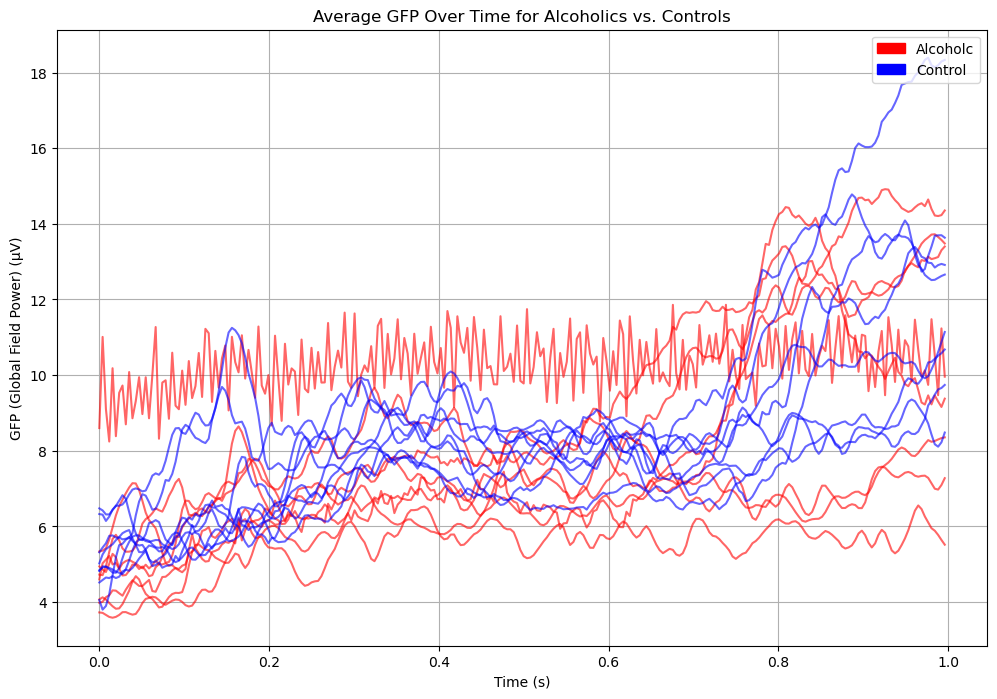

In [140]:
# Hent ut gjennomsnittlig sensorverdi over tid for hver deltaker
gfp_avg_df = gfp_df.groupby(['name', 'time', 'subject_identifier'])['GFP'].mean().reset_index()

# Drops rows with patient co2a0000371, as this patient has unusal readings in comparison to other patiens

#idx_list = gfp_avg_df[((gfp_avg_df.name == 'co2a0000371'))].index
#gfp_avg_df = gfp_avg_df.drop(idx_list)

# Grupper etter deltakernavn og identifikator for visualisering
participants = gfp_avg_df['name'].unique()
plt.figure(figsize=(12, 8))

# Plotte linjer for hver deltaker med farge basert på om de er alkoholikere eller kontrollpersoner
for participant in participants:
    # Filtrer ut data for denne deltakeren
    participant_data = gfp_avg_df[gfp_avg_df['name'] == participant]
    
    # Velg farge basert på identifikatoren
    color = 'red' if participant_data['subject_identifier'].iloc[0] == 'a' else 'blue'
    
    # Plott linjer for hver deltaker
    plt.plot(participant_data['time'], participant_data['GFP'], color=color, alpha=0.6)


# Legg til tittel og etiketter
plt.title('Average GFP Over Time for Alcoholics vs. Controls')
plt.xlabel('Time (s)')
plt.ylabel('GFP (Global Field Power) (µV)')

# Lage legend
a_patch = mpatches.Patch(color = 'red', label = 'Alcoholc')
c_patch = mpatches.Patch(color = 'blue', label = 'Control')
plt.legend(handles=[a_patch, c_patch], loc='upper right')

plt.grid(True)
# Vise grafen
plt.show()

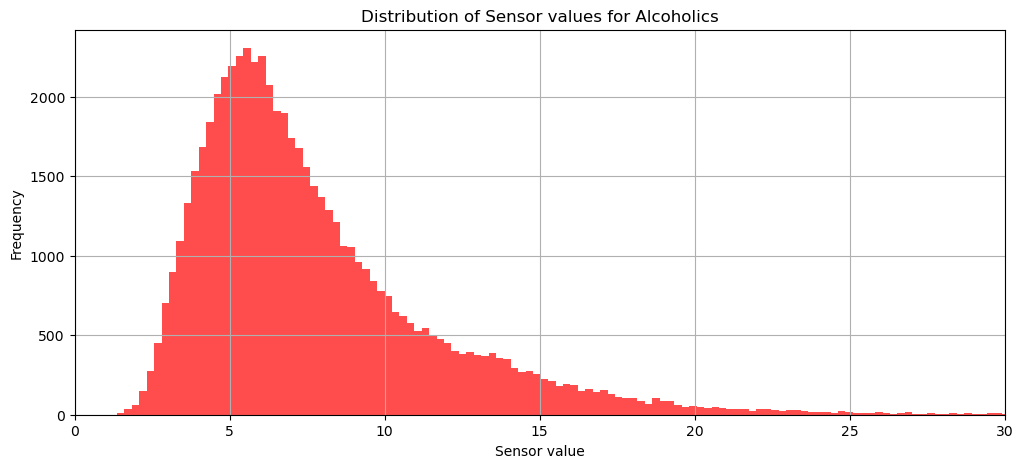

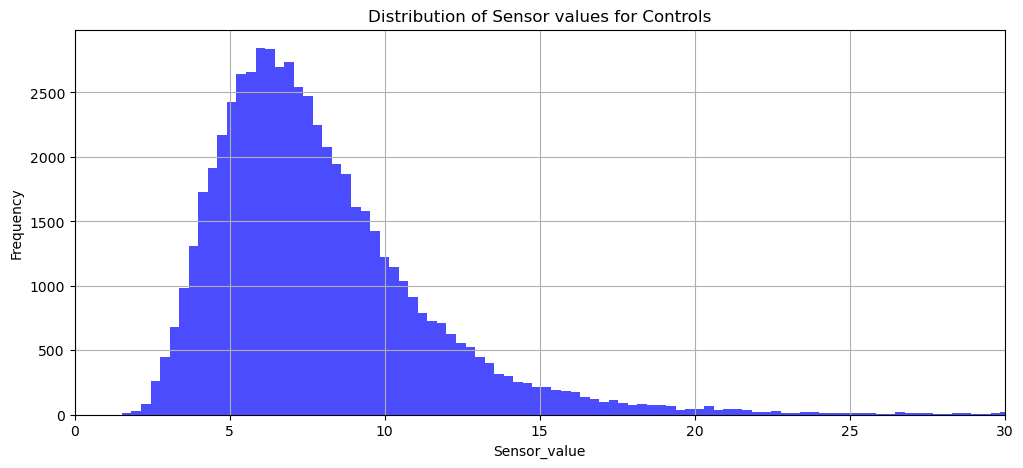

In [141]:
# Del dataene i alkoholikere og kontrollpersoner
alcoholics_data = gfp_df[gfp_df['subject_identifier'] == 'a']
controls_data = gfp_df[gfp_df['subject_identifier'] == 'c']

# Opprett separate figurer for hver gruppe
plt.figure(figsize=(12, 5))
# Histogram for alkoholikere
plt.hist(alcoholics_data['GFP'], bins=300, color='red', alpha=0.7)
plt.title('Distribution of Sensor values for Alcoholics')
plt.xlabel('Sensor value')
plt.ylabel('Frequency')

plt.xlim(0,30)
plt.grid(True)
plt.show()

# Nytt figur for kontrollpersoner
plt.figure(figsize=(12, 5))
plt.hist(controls_data['GFP'], bins=300, color='blue', alpha=0.7)
plt.title('Distribution of Sensor values for Controls')
plt.xlabel('Sensor_value')
plt.ylabel('Frequency')

plt.xlim(0,30)
plt.grid(True)
plt.show()

In [142]:
def extract_features(data):
    features = []


    for window in data:
        window = window.reset_index(drop='True')
        mean = np.mean(window['GFP'])
        variance = np.var(window['GFP'])
        rms = np.sqrt(np.mean(window['GFP']**2))
        skewness = stats.skew(window['GFP'])
        kurtosis = stats.kurtosis(window['GFP'])

        subject_identifier = window.iloc[0, 1]
        features.append([mean, variance, rms, skewness, kurtosis, subject_identifier])

    return pd.DataFrame(features, columns=['Mean', 'Variance', 'RMS', 'Skewness', 'Kurtosis', 'Subject_identifier']).reset_index(drop='True')

features_df = extract_features(eeg.split_into_windows(gfp_df))

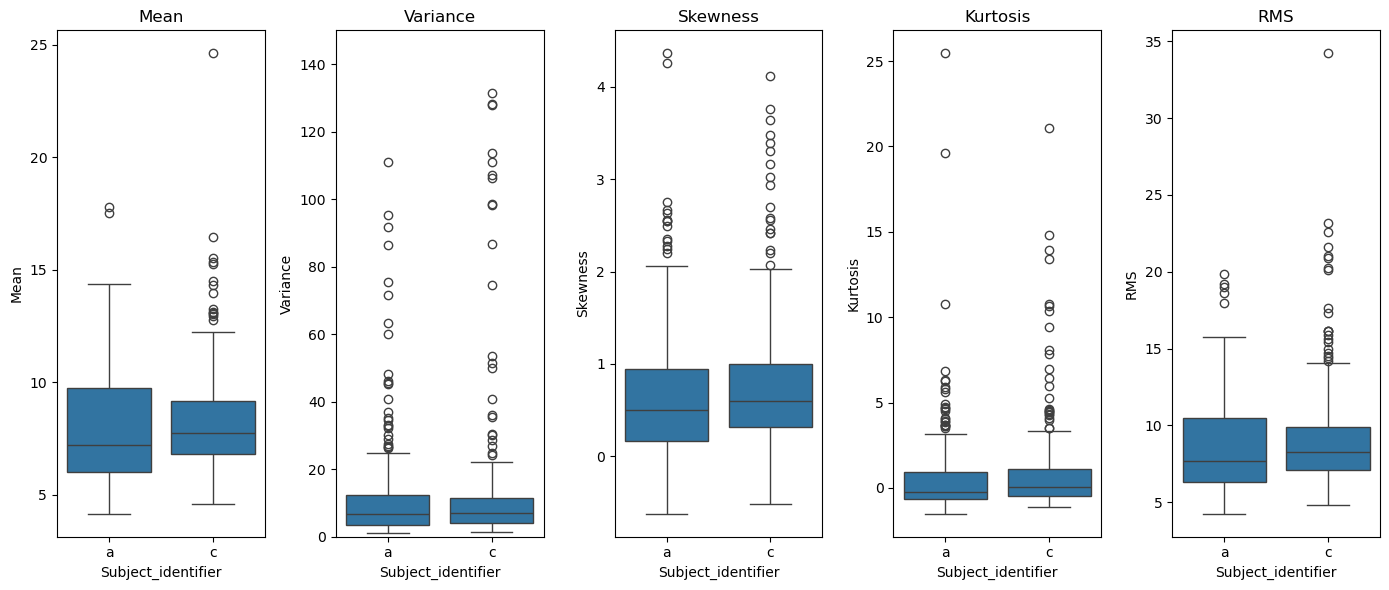

In [151]:
"""Lag boksplotter for alle statistiske funksjoner gruppert etter alkoholiker/kontroll."""
features = ['Mean', 'Variance', 'Skewness', 'Kurtosis', 'RMS']
# Definer plottenes layout
plt.figure(figsize=(14,6))
# Lag boksplott for hver funksjon
for i, feature in enumerate(features):
    plt.subplot(1, len(features), i + 1)
    sns.boxplot(x=features_df['Subject_identifier'], y = features_df[feature], data=features_df)
    if feature == 'Variance':
        plt.ylim(0,150)

    plt.title(feature)

plt.tight_layout()
plt.show()

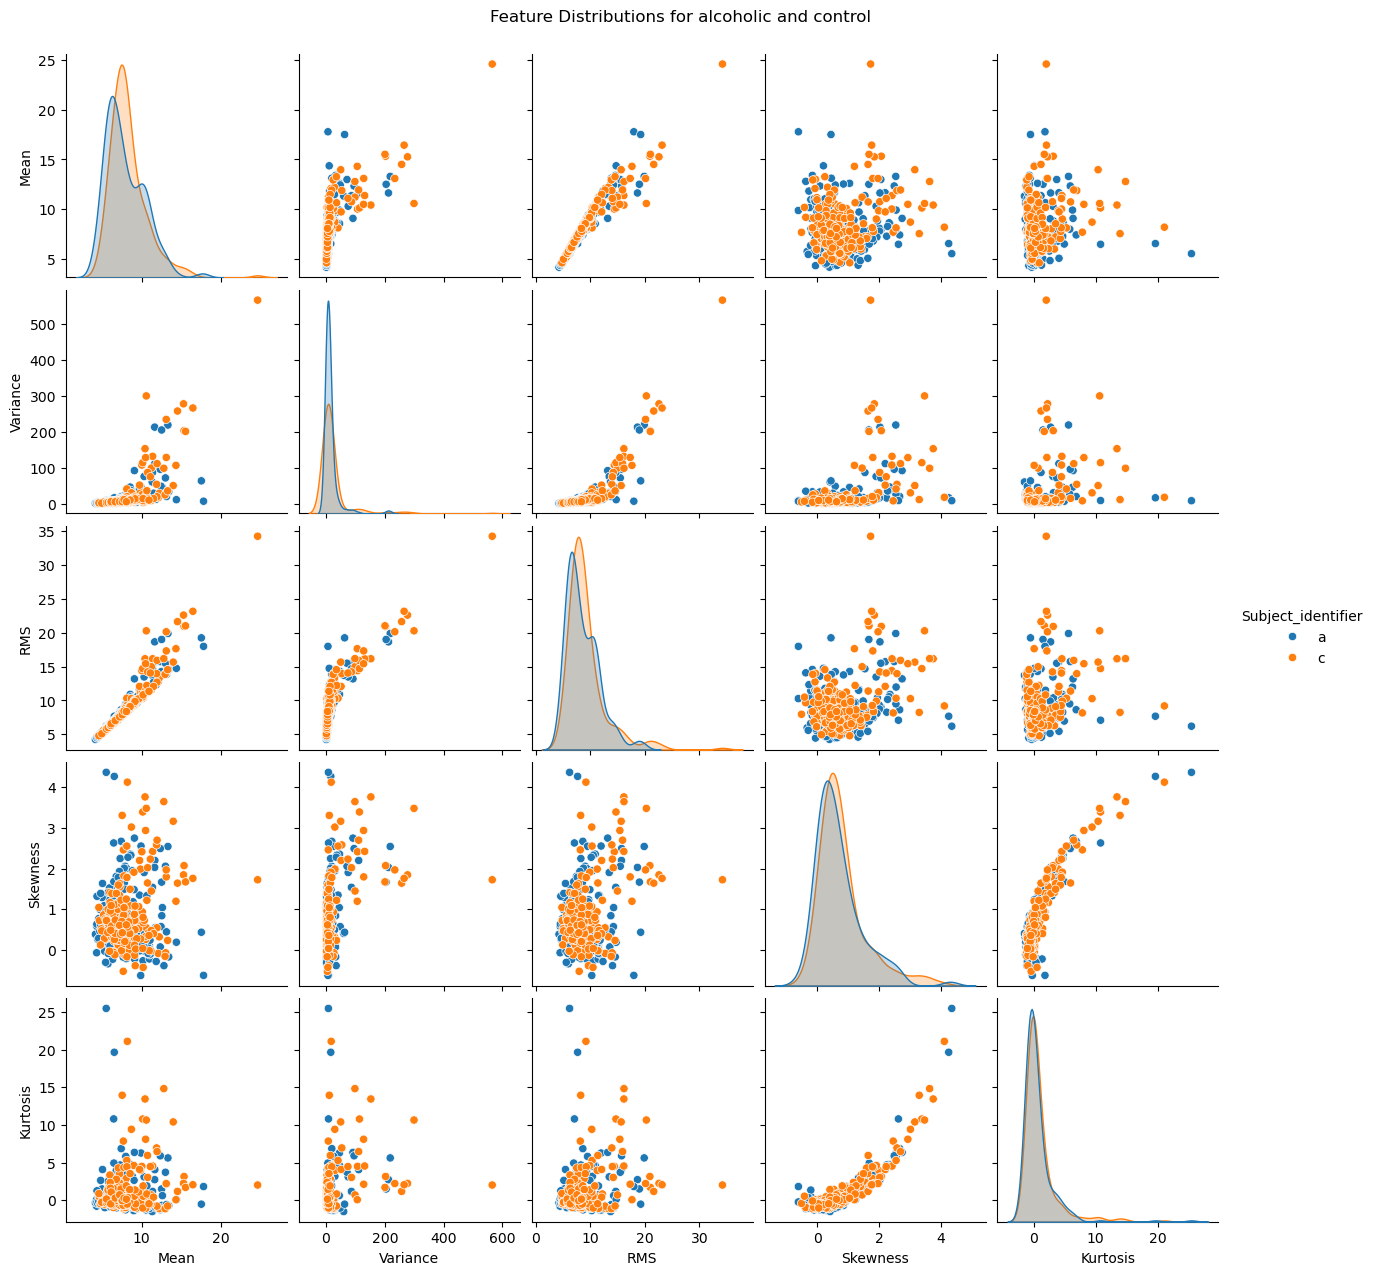

In [144]:
#pairplot_features = feature_data[['mean_amplitude', 'variance', 'rms','subject_identifier']]

sns.pairplot(features_df, hue='Subject_identifier' ,diag_kind='kde')
plt.suptitle('Feature Distributions for alcoholic and control', y=1.02)

plt.show()


In [145]:
freq_data_control = eeg.apply_fft(df[df['subject_identifier'] == 'c'], 256)
freq_data_alcoholic = eeg.apply_fft(df[df['subject_identifier'] == 'a'], 256)

In [146]:
freq_data_control_df = pd.DataFrame(freq_data_control)
freq_data_control_df['subject_identifier'] = 'c'
freq_data_alcoholic_df = pd.DataFrame(freq_data_alcoholic)
freq_data_alcoholic_df['subject_identifier'] = 'a'

freq_data_combined_df = pd.concat([freq_data_control_df, freq_data_alcoholic_df])

# Omformer DataFrames for å gjøre det lettere å plotte
freq_data_combined_df = freq_data_combined_df.reset_index()
freq_data_combined_df[['trial_number', 'sensor_position']] = pd.DataFrame(freq_data_combined_df[0].tolist(), index=freq_data_combined_df.index)
freq_bands_df = pd.json_normalize(freq_data_combined_df[1])
freq_data_combined_df = pd.concat([freq_data_combined_df[['trial_number', 'sensor_position', 'subject_identifier']], freq_bands_df], axis=1)

freq_data_grouped_df = freq_data_combined_df.groupby(['trial_number', 'subject_identifier'])[['alpha', 'beta', 'delta', 'theta']].mean().reset_index()

In [147]:
def plot_amplitude_comparison(df):
    """
    Visualiser sammenligning av amplitude mellom alkoholikere og kontrollpersoner for hvert trial_number.
    """
    # Sett opp plottet
    plt.figure(figsize=(14, 8))

    # Smelt DataFrame for å gjøre plotting enklere (fra bred til lang format)
    melted_df = pd.melt(df, id_vars=['trial_number', 'subject_identifier'], value_vars=['alpha', 'beta', 'delta', 'theta'],
                        var_name='Frequency Band', value_name='Amplitude')
    
    # Lag et stolpediagram for hver frekvensbånd, sammenlignet mellom gruppene
    sns.barplot(x='trial_number', y='Amplitude', hue='subject_identifier', data=melted_df, ci=None, palette='Set1')

    # Legg til tittel og etiketter
    plt.title('Comparison of Amplitude Between Alcoholics and Controls by Trial', fontsize=16)
    plt.xlabel('Trial Number')
    plt.ylabel('Amplitude (µV)')
    plt.legend(title='Group')
    plt.grid(True)
    plt.xticks(rotation=45)
    
    # Vis plottet
    plt.tight_layout()
    plt.show()

def plot_boxplot_by_frequency_band(df):
    """
    Visualiser fordelingen av amplituder i ulike frekvensbånd for alkoholikere og kontrollpersoner ved bruk av boxplots.
    """
    plt.figure(figsize=(14, 8))

    # Smelt DataFrame for enklere plotting
    melted_df = pd.melt(df, id_vars=['trial_number', 'subject_identifier'], value_vars=['alpha', 'beta', 'delta', 'theta'],
                        var_name='Frequency Band', value_name='Amplitude')
    
    # Lag et boxplot for hvert frekvensbånd
    sns.boxplot(x='Frequency Band', y='Amplitude', hue='subject_identifier', data=melted_df, palette='Set1')

    # Legg til tittel og etiketter
    plt.title('Amplitude Distribution by Frequency Band', fontsize=16)
    plt.xlabel('Frequency Band')
    plt.ylim(0,3*np.power(10,6))
    plt.ylabel('Amplitude (µV)')
    plt.grid(True)
    plt.legend(title='Group')
    
    plt.tight_layout()
    plt.show()

C:\Users\sim-t\AppData\Local\Temp\ipykernel_13276\2987602710.py:13: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='trial_number', y='Amplitude', hue='subject_identifier', data=melted_df, ci=None, palette='Set1')


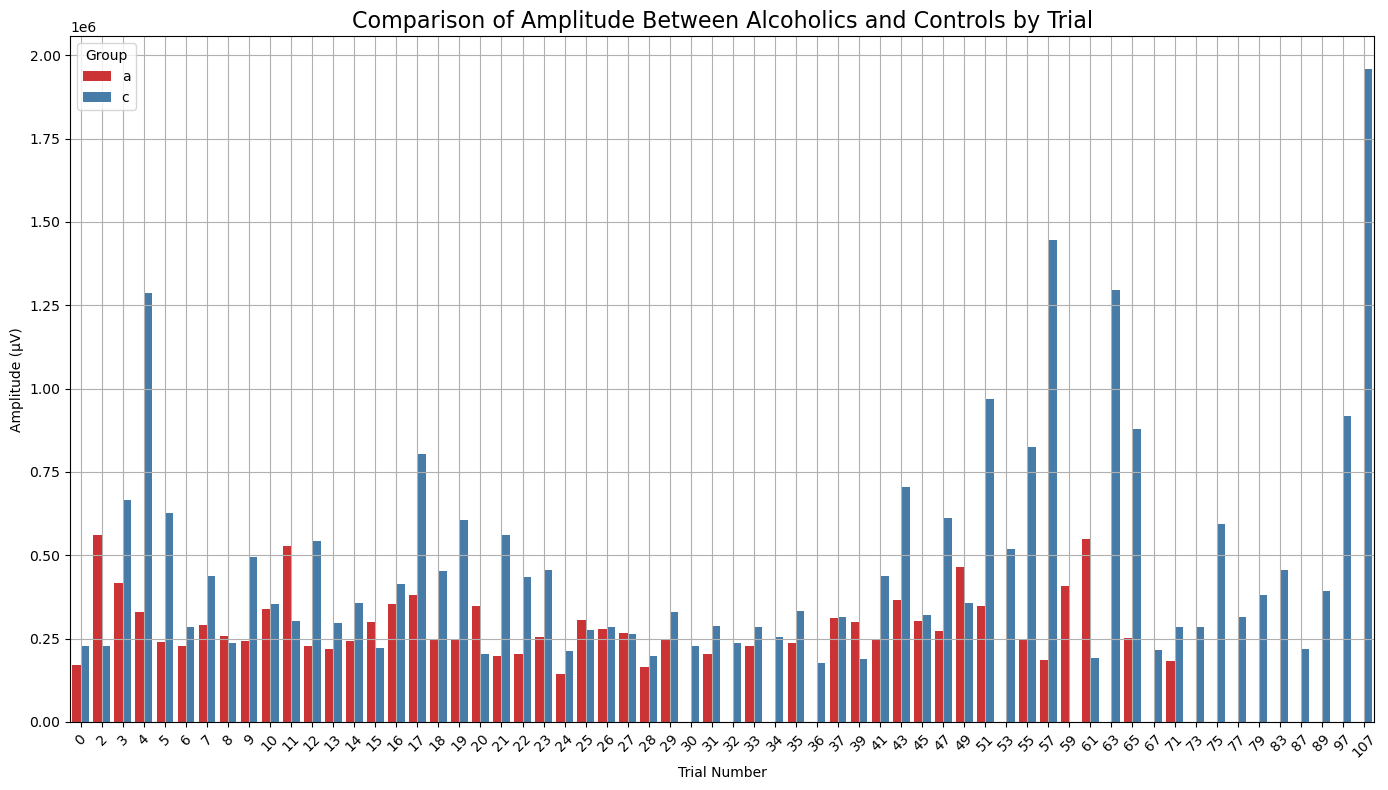

In [148]:
plot_amplitude_comparison(freq_data_grouped_df)

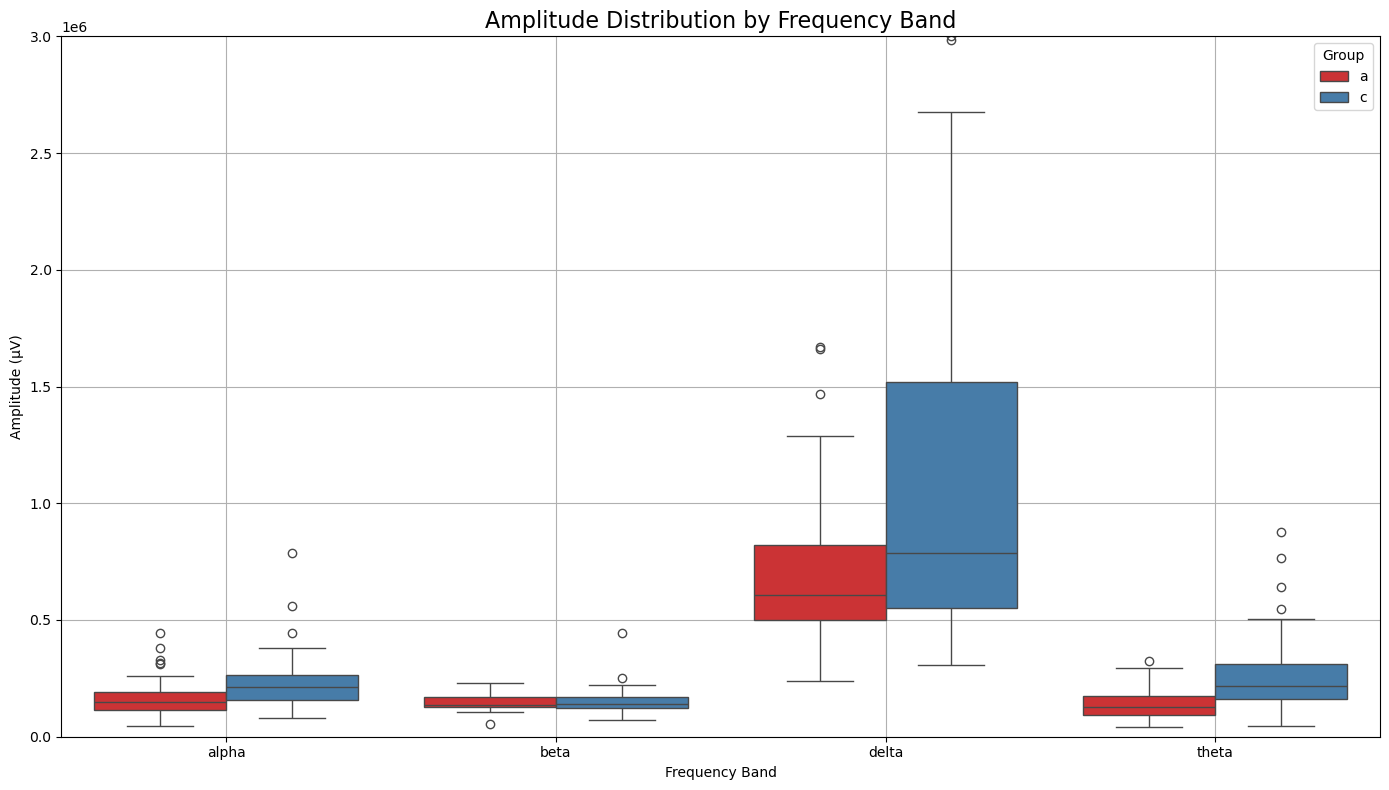

In [149]:
plot_boxplot_by_frequency_band(freq_data_grouped_df)